## Bayesian optimization libraries

There are numerous Bayesian optimization libraries out there and giving a comprehensive overview is not the goal of this article. Instead, I'll pick two that I used in the past and show the minimum setup needed to get the previous example running.

### Scikit-optimize

[Scikit-optimize](https://scikit-optimize.github.io/) is a library for sequential model-based optimization that is based on [scikit-learn](http://scikit-learn.org/). It also supports Bayesian optimization using Gaussian processes. The API is designed around minimization, hence, we have to provide negative objective function values.  The results obtained here slightly differ from previous results because of non-deterministic optimization behavior and different noisy samples drawn from the objective function.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern
from bayesian_optimization_util import plot_approximation, plot_acquisition, plot_convergence
from sklearn.base import clone
from skopt import gp_minimize
from skopt.learning import GaussianProcessRegressor
from skopt.learning.gaussian_process.kernels import ConstantKernel, Matern
%matplotlib inline


In [7]:
bounds = np.array([[-2.0, 2.0]])
noise = 0.2

def f(X, noise=noise):
    return -np.sin(3*X) - X**2 + 0.7*X + noise * np.random.randn(*X.shape)

X_init = np.array([[-0.9], [1.1]])
Y_init = f(X_init)

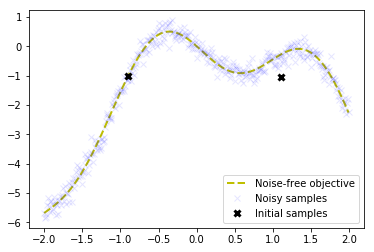

In [9]:
# Dense grid of points within bounds
X = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)

# Noise-free objective function values at X 
Y = f(X,0)

# Plot optimization objective with noise level 
plt.plot(X, Y, 'y--', lw=2, label='Noise-free objective')
plt.plot(X, f(X), 'bx', lw=1, alpha=0.1, label='Noisy samples')
plt.plot(X_init, Y_init, 'kx', mew=3, label='Initial samples')
plt.legend();

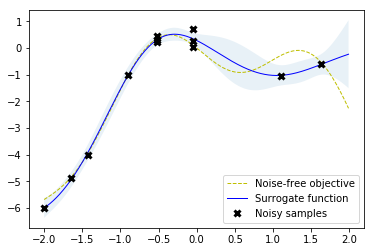

In [10]:
# Use custom kernel and estimator to match previous example
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)

r = gp_minimize(lambda x: -f(np.array(x))[0], 
                bounds.tolist(),
                base_estimator=gpr,
                acq_func='EI',      # expected improvement
                xi=0.01,            # exploitation-exploration trade-off
                n_calls=10,         # number of iterations
                n_random_starts=0,  # initial samples are provided
                x0=X_init.tolist(), # initial samples
                y0=-Y_init.ravel())

# Fit GP model to samples for plotting results
gpr.fit(r.x_iters, -r.func_vals)

# Plot the fitted model and the noisy samples
plot_approximation(gpr, X, Y, r.x_iters, -r.func_vals, show_legend=True)

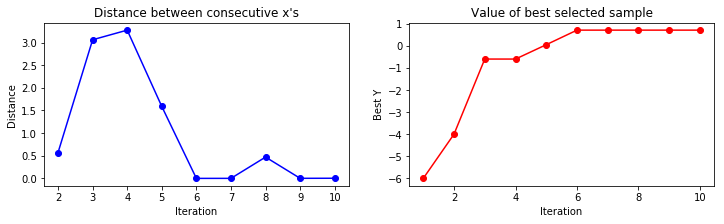

In [11]:
plot_convergence(np.array(r.x_iters), -r.func_vals)

## GPyOpt

[GPyOpt](http://sheffieldml.github.io/GPyOpt/) is a Bayesian optimization library based on [GPy](https://sheffieldml.github.io/GPy/). The abstraction level of the API is comparable to that of scikit-optimize. The `BayesianOptimization` API provides a `maximize` parameter to configure whether the objective function shall be maximized or minimized (default). In version 1.2.1, this seems to be ignored when providing initial samples, so we have to negate their target values manually in the following example. Also, the built-in `plot_acquisition` and `plot_convergence` methods display the minimization result in any case. Again, the results obtained here slightly differ from previous results because of non-deterministic optimization behavior and different noisy samples drawn from the objective function. 

In [13]:
import GPy
import GPyOpt
from GPyOpt.methods import BayesianOptimization

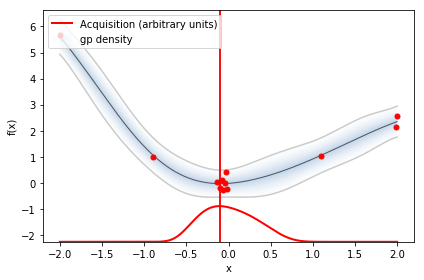

In [14]:
import GPy
import GPyOpt

from GPyOpt.methods import BayesianOptimization

kernel = GPy.kern.Matern52(input_dim=1, variance=1.0, lengthscale=1.0)
bds = [{'name': 'X', 'type': 'continuous', 'domain': bounds.ravel()}]

optimizer = BayesianOptimization(f=f, 
                                 domain=bds,
                                 model_type='GP',
                                 kernel=kernel,
                                 acquisition_type ='EI',
                                 acquisition_jitter = 0.01,
                                 X=X_init,
                                 Y=-Y_init,
                                 noise_var = noise**2,
                                 exact_feval=False,
                                 normalize_Y=False,
                                 maximize=True)

optimizer.run_optimization(max_iter=10)
optimizer.plot_acquisition()

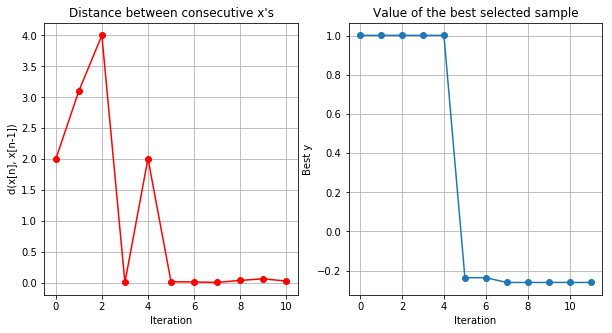

In [15]:
optimizer.plot_convergence()